# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

SL-Ensemble of DoubleJets

In [6]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=512, nx=1024)
doubleJetCase_args, doubleJetCase_init = doubleJetCase.getInitConditions()

In [7]:
args = {key: doubleJetCase_args[key] for key in ('nx', 'ny', 'dx', 'dy', 'gpu_ctx', 'boundary_conditions')}
args["gpu_stream"] = gpu_stream

In [8]:
data_args = {"eta" : doubleJetCase_init["eta0"],
             "hu" : doubleJetCase_init["hu0"],
             "hv" : doubleJetCase_init["hv0"],
             "Hi" : doubleJetCase_args["H"]}

In [9]:
sample_args = {"f": doubleJetCase_args["f"], "g": doubleJetCase_args["g"]}

In [10]:
sim_model_error_basis_args = {
                            "basis_x_start": 2, 
                            "basis_x_end": 8,
                            "basis_y_start": 1,
                            "basis_y_end": 7,

                            "kl_decay": 1.25,
                            "kl_scaling": 0.025,
                            }

sim_model_error_time_step = 60.0                        

In [11]:
from utils.DoubleJetSL import * 
SL_ensemble = initSLensemble(100, args, data_args, sample_args, 
                    init_model_error_basis_args=None, 
                    sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=sim_model_error_time_step)

Two-level ensemble

In [12]:
coarse_doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
coarse_doubleJetCase_args, coarse_doubleJetCase_init = coarse_doubleJetCase.getInitConditions()

In [13]:
coarse_args = {key: coarse_doubleJetCase_args[key] for key in ('nx', 'ny', 'dx', 'dy', 'gpu_ctx', 'boundary_conditions')}
coarse_args["gpu_stream"] = gpu_stream

In [14]:
coarse_data_args = {"eta" : coarse_doubleJetCase_init["eta0"],
             "hu" : coarse_doubleJetCase_init["hu0"],
             "hv" : coarse_doubleJetCase_init["hv0"],
             "Hi" : coarse_doubleJetCase_args["H"]}

In [15]:
ML_Nes = [100, 50]
args_list = [coarse_args, args]
data_args_list = [coarse_data_args, data_args]

In [16]:
sim_mekls = []
for l_idx in range(len(args_list)): 
    sim_mekls.append( ModelErrorKL.ModelErrorKL(**args_list[l_idx], **sim_model_error_basis_args) )

In [17]:
## MultiLevel ensemble
ML_ensemble = []

# 0-level
lvl_ensemble = []
for i in range(ML_Nes[0]):
    if i % 100 == 0: print(i)
    sim = make_sim(args_list[0], sample_args, init_fields=data_args_list[0])

    sim.model_error = sim_mekls[0]
    sim.model_time_step = sim_model_error_time_step
    lvl_ensemble.append( sim )

ML_ensemble.append(lvl_ensemble)

# diff-levels
for l_idx in range(1,len(ML_Nes)):
    print(l_idx)
    lvl_ensemble0 = []
    lvl_ensemble1 = []
    
    for e in range(ML_Nes[l_idx]):
        sim0 = make_sim(args_list[l_idx], sample_args, init_fields=data_args_list[l_idx])
        sim1 = make_sim(args_list[l_idx-1], sample_args, init_fields=data_args_list[l_idx-1])

        sim0.model_error = sim_mekls[l_idx]
        sim1.model_error = sim_mekls[l_idx-1]

        sim0.model_time_step = sim_model_error_time_step
        sim1.model_time_step = sim_model_error_time_step

        lvl_ensemble0.append(sim0)
        lvl_ensemble1.append(sim1)
    
    ML_ensemble.append([lvl_ensemble0,lvl_ensemble1])

0
1


In [18]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

Generate observations

In [19]:
truth = CDKLM16.CDKLM16(**doubleJetCase_args, **doubleJetCase_init)
truth.updateDt()

grid_args = {"nx" : doubleJetCase_args["nx"],
             "ny" : doubleJetCase_args["ny"],
             "dx" : doubleJetCase_args["dx"],
             "dy" : doubleJetCase_args["dy"],
             "gpu_ctx" : doubleJetCase_args["gpu_ctx"],
             "gpu_stream": truth.gpu_stream,
             "boundary_conditions" : doubleJetCase_args["boundary_conditions"]
             }

truth_mekl = ModelErrorKL.ModelErrorKL(**grid_args, **sim_model_error_basis_args)
truth.model_error = truth_mekl
truth.model_time_step = sim_model_error_time_step

# truth.dataAssimilationStep(6*60*60)

In [20]:
from utils.DoubleJetPlot import *

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

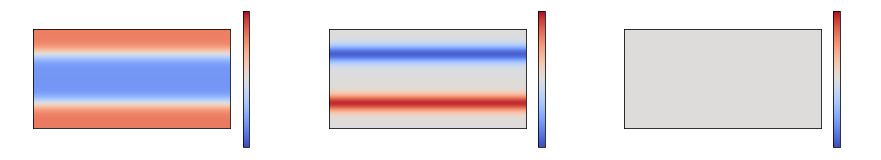

In [21]:
imshowSim(truth, eta_vlim=3.5, huv_vlim=750)

In [22]:
xdim = args["nx"]*args["dx"]
ydim = args["ny"]*args["dy"]

In [23]:
xs = np.linspace(0, xdim, 10, endpoint=False)
ys = np.linspace(0, ydim, 5, endpoint=False)

In [24]:
[obs_xs, obs_ys] = np.array(np.meshgrid(xs, ys)).T.reshape(-1, 2).T

In [25]:
R = [0.05, 1.0, 1.0]

In [26]:
from gpuocean.dataassimilation import MLEnKFOcean
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)

In [27]:
from importlib import reload
reload(MLEnKFOcean)

<module 'gpuocean.dataassimilation.MLEnKFOcean' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/dataassimilation/MLEnKFOcean.py'>

In [28]:
precomp_GC = []
r = 5e4
for obs_x, obs_y in zip(obs_xs, obs_ys):
    precomp_GC.append( MLEnKF.GCweights(obs_x, obs_y, r) )

(<matplotlib.image.AxesImage at 0x7fe6d02c7810>, 52031.25)

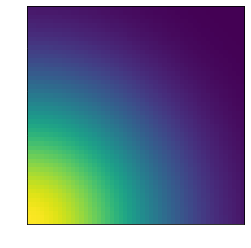

In [51]:
plt.imshow(MLEnKF.GCweights(obs_xs[0], obs_ys[0], 5e4)[0:50,0:50]), 40*doubleJetCase_args["dx"] 

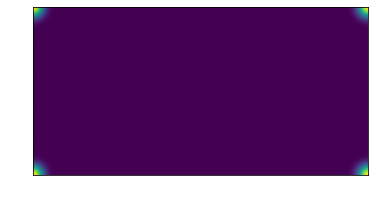

In [47]:
plt.imshow(precomp_GC[0])

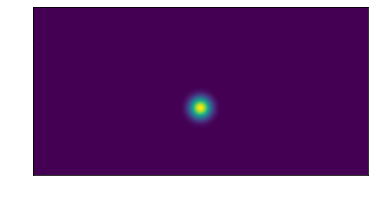

In [30]:
plt.imshow(precomp_GC[27])

In [31]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
obses = np.zeros((len(obs_xs),3))
for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    Hx, Hy = SLobsCoord2obsIdx(SL_ensemble, obs_x, obs_y)
    obses[h] = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

SL DA

In [32]:
SL_prior = copy.deepcopy(SLdownload(SL_ensemble))
# SLupload(SL_ensemble, SL_prior)

In [33]:
for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    print(h)
    obs = obses[h]

    SL_K = SLEnKF(SL_ensemble, obs, obs_x, obs_y, R=R, obs_var=slice(1,3), 
            relax_factor=0.5, localisation_weights=precomp_GC[h])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

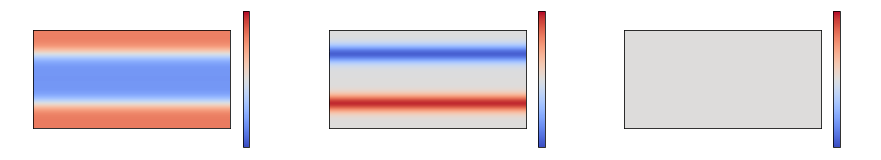

In [34]:
imshow3(SLestimate(SL_ensemble, np.mean), eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

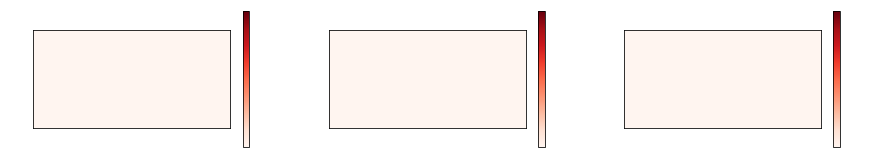

In [35]:
imshow3var(SLestimate(SL_ensemble, np.std), eta_vlim=0.5, huv_vlim=100)

ML DA

In [36]:
ML_prior = copy.deepcopy(MLOceanEnsemble.download())

In [37]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)
for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    print(h)
    obs = obses[h]
    
    ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, 
                            r=r, obs_var=slice(1,3), relax_factor=0.5, 
                            min_localisation_level=0,
                            precomp_GC=precomp_GC[h])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

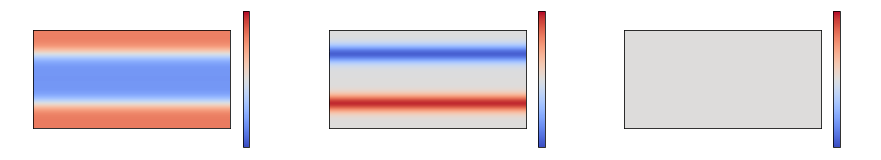

In [38]:
imshow3(MLOceanEnsemble.estimate(np.mean), eta_vlim=3.5, huv_vlim=750)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

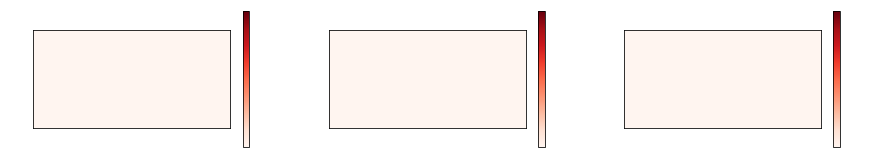

In [39]:
imshow3var(MLOceanEnsemble.estimate(np.std), eta_vlim=0.5, huv_vlim=100)